/tmp/ipython-input-4201201395.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(X[col], errors='coerce').notna().all():  # If the column is a date
/tmp/ipython-input-4201201395.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(X[col], errors='coerce').notna().all():  # If the column is a date
/tmp/ipython-input-4201201395.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(X[col], errors='coerce').notna().all():  # If the column is a date
/tmp/ipython-input-4201201395.py:47: UserWarning: Could not infer format, so

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        60
           1       0.78      0.75      0.77        61
           2       0.79      0.72      0.75        61

    accuracy                           0.82       182
   macro avg       0.82      0.82      0.82       182
weighted avg       0.81      0.82      0.82       182



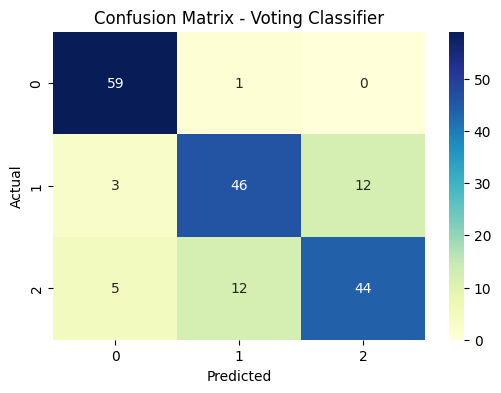


Per-Species Accuracy:
 Amphibian: 0.8000
 Aquatic: 0.7500
 Bird: 0.8636
 Insect: 0.9167
 Mammal: 0.7660
 Reptile: 0.7308

Overall Accuracy: 0.8187


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install catboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

# Load dataset
file_path = "/content/drive/MyDrive/Impact of 5G Electromagnetic Radiation on Animal Behaviour, Health, and Ecosystems.csv"
df = pd.read_csv(file_path)

# Strip whitespace from column names to avoid mismatches
df.columns = df.columns.str.strip()

# Define target and species columns (Update with correct names based on your dataset)
target_column = 'Activity Pattern'
species_column = 'Species Type'

# Ensure that the target and species columns exist
if target_column not in df.columns or species_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' or species column '{species_column}' not found.")

# Separate features and target
X = df.drop(columns=[target_column, species_column])
y = df[target_column]
species = df[species_column]

# Encode target labels to numeric values (CatBoost requires numeric labels)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Encode species labels to numeric values
species_encoder = LabelEncoder()
species_encoded = species_encoder.fit_transform(species)

# Handle missing values
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# Convert all date columns to numeric (e.g., Unix timestamp)
for col in categorical_cols:
    if pd.to_datetime(X[col], errors='coerce').notna().all():  # If the column is a date
        X[col] = pd.to_datetime(X[col], errors='coerce').astype(np.int64) // 10**9  # Convert to Unix timestamp

# Apply label encoding to all categorical columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Handle missing values
X[numerical_cols] = X[numerical_cols].apply(pd.to_numeric, errors='coerce')
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])

# Apply scaling to numerical columns
scaler = StandardScaler()
if len(numerical_cols) > 0:  # Check if there are any numerical columns
    X_scaled = X.copy()
    X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])
else:
    X_scaled = X.copy()

# Oversample using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_encoded)

# Match species length after SMOTE
species_balanced = np.resize(species_encoded, len(X_balanced))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, sp_train, sp_test = train_test_split(
    X_balanced, y_balanced, species_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Model definitions
catboost = CatBoostClassifier(verbose=0, random_state=42)

rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(n_estimators=150, random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('catboost', catboost), ('rf', rf), ('gb', gb)],
    voting='soft'
)

# Train the model
voting_clf.fit(X_train, y_train)

# Predict the test set results
y_pred = voting_clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Per-species accuracy
species_accuracy = {}
sp_test_series = pd.Series(sp_test).reset_index(drop=True)

# Map encoded species back to original species names
species_mapping = {i: sp for i, sp in enumerate(species_encoder.classes_)}

for sp_id in np.unique(sp_test_series):
    indices = sp_test_series[sp_test_series == sp_id].index
    acc = accuracy_score(y_test[indices], y_pred[indices])
    species_accuracy[sp_id] = acc

# Print per-species accuracy
print("\nPer-Species Accuracy:")
for sp_id, acc in species_accuracy.items():
    species_name = species_mapping.get(sp_id, "Unknown Species")
    print(f" {species_name}: {acc:.4f}")

# Overall Accuracy
print(f"\nOverall Accuracy: {accuracy_score(y_test, y_pred):.4f}")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
